In [92]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# for heatmaps
from scipy.ndimage.filters import gaussian_filter

#for model2
import scipy.ndimage

# for model4
from scipy.ndimage.filters import maximum_filter
from skimage.feature import peak_local_max


import ast # parsing
import re # parsing
import time, random

import datetime
plt.rcParams['figure.figsize'] = (11.0, 7.0)
%matplotlib inline
plt.rcParams['figure.figsize'] = (11.0, 7.0)



**Basic data preprocessing**

Read data, drop first column, and safely evaluate strings.

In [93]:
df = pd.read_csv("tracks.csv")
df = df.drop(df.columns[[0]], axis=1)

def string_to_list_datetime(string):
    # this functions does safe eval() on strings like [datetime(...), ]
    mall = re.findall(r'datetime(\((\d+)(,\s*\d+)*\))', string)
    arr = []
    for m in mall:
        args = ast.literal_eval(m[0])
        arr.append(datetime.datetime(*args))
    return np.array(arr)

def string_to_list(string):
    # safe eval() on strings "[1, 2, ..]"
    return np.array(ast.literal_eval(string))

# apply safe eval()
df["positions_x"] = df["positions_x"].apply(string_to_list)
df["positions_y"] = df["positions_y"].apply(string_to_list)
df["positions_time"] = df["positions_time"].apply(string_to_list_datetime)


Now let's examine the data:
 - count duplicates
 - check for missing values

In [94]:

def count_occurencies(df):
    # plots a histogram of occurencies 
    
    df['positions_time'] = df['positions_time'].apply(lambda x: hash(tuple(x)))
    df['positions_x'] = df['positions_x'].apply(lambda x: hash(tuple(x)))
    df['positions_y'] = df['positions_y'].apply(lambda x: hash(tuple(x)))
    a = df.groupby(df.columns.tolist(),as_index=False).size()
    plt.hist(a)
    plt.show()
    
#count_occurencies(df.copy())

In [95]:
X_max = max(np.array([max(e) for e in df["positions_x"].values]))
X_min = min(np.array([min(e) for e in df["positions_x"].values]))
Y_max = max(np.array([max(e) for e in df["positions_y"].values]))
Y_min = min(np.array([min(e) for e in df["positions_y"].values]))

Plot **sample** random trajectories

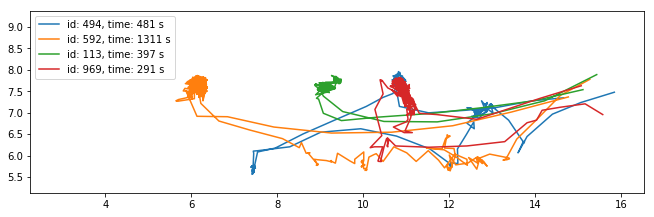

In [96]:
def plot_sample_trajectory(df, idx):
    label =  "id: "+str(idx) + ", time: "+ str(round((df["positions_time"][idx][-1] - df["positions_time"][idx][0]).total_seconds())) + " s"
    plt.plot(np.array(df["positions_x"][idx]), np.array(df["positions_y"][idx]), label=label)
    plt.gca().set_aspect('equal')
    plt.xlim(X_min, X_max)
    plt.ylim(Y_min, Y_max)

for i in random.sample(range(len(df)),4):
    plot_sample_trajectory(df, i)
    
plt.legend(loc="upper left")
plt.show()

How do **all** trajectories look like (superimposed)?

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


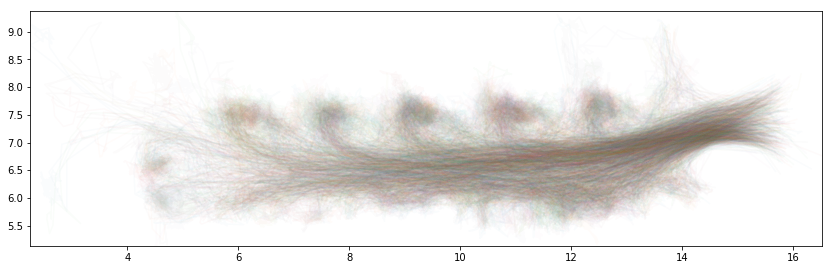

In [97]:
def plot_trajectory(df, idx, alpha):
    plt.plot(np.array(df["positions_x"][idx]), np.array(df["positions_y"][idx]), alpha=alpha)
    plt.gca().set_aspect('equal')
    plt.xlim(X_min, X_max)
    plt.ylim(Y_min, Y_max)
    
fig = plt.figure()
for i in range(len(df)):
    plot_trajectory(df, i, 0.02)
    
fig.subplots_adjust(bottom = 0)
fig.subplots_adjust(top = 1)
fig.subplots_adjust(right = 1)
fig.subplots_adjust(left = 0)
fig.savefig("background.png", bbox_inches='tight', transparent=True, pad_inches=0)

fig.show()



Where do trajectories **start/end**?

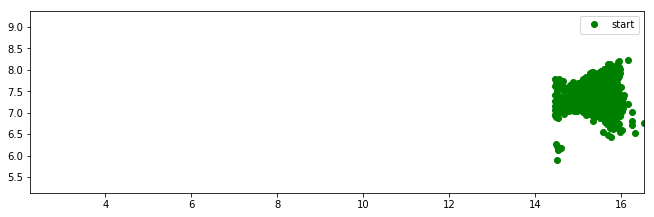

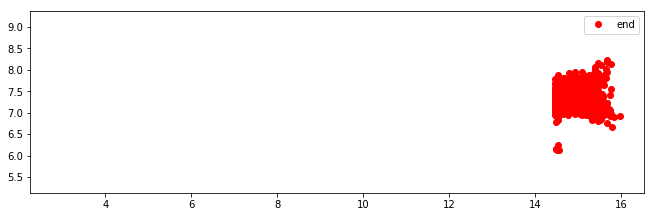

In [98]:

Xstart = [df["positions_x"][i][0] for i in range(len(df))]
Ystart = [df["positions_y"][i][0] for i in range(len(df))]

plt.plot(Xstart,Ystart, 'o', color='green', label='start')
plt.gca().set_aspect('equal')
plt.ylim(Y_min, Y_max)
plt.xlim(X_min, X_max)
plt.legend()
plt.show()

# ends
plt.subplot(111)
Xend = [df["positions_x"][i][-1] for i in range(len(df))]
Yend = [df["positions_y"][i][-1] for i in range(len(df))]

plt.plot(Xend, Yend, 'o', color='red', label='end')
plt.gca().set_aspect('equal')
plt.xlim(X_min, X_max)
plt.ylim(Y_min, Y_max)
plt.legend()
plt.show()

We can see that all data start in relatively small region

------

Where do customers spend time in the shop? 

To answer this question, we generate a **heatmap** giving a proportion of spent time at given place.

In [120]:
def generate_equal_customer_heatmap(df, bins=10, contrast=1, no_plot=False):
    """
        Info:
          will generate a heatmap of time spent and visualise it. Each customer has equal weight.
        
        Params:
          df = DataFrame
          bins = number of bins
          contrast = data are **(1/contrast) -> so higher contrast than 1 makes weak data brighter
          no_plot = should heatmap be plotted or just returned?
          
    """
    xpos = np.array([])
    ypos = np.array([])
    
    for e in df["positions_x"].values:
        xpos = np.append(xpos,e)
    for e in df["positions_y"].values:
        ypos = np.append(ypos,e)
        
    # create the mesh (bins) and put them into lists a,b
    _,a,b = np.histogram2d(xpos,ypos, bins=bins, range=[[X_min,X_max], [Y_min,Y_max]])
    
    # we iterate over customers and calculate "heatmap" for each separately, such that is normalised per customer
    heatmap = np.zeros((bins,bins))
    for x,y,t in zip(df["positions_x"].values, df["positions_y"].values, df["positions_time"].values):
        
        # data are weighted by the amount of time spent at given place, capped at dt_max since data might be discontinuous
        weights = np.vectorize(max)(1.2,np.array([e.total_seconds() for e in np.diff(t)]))
        weights = np.append(weights, 1.)
        partial_heatmap, _,_ = np.histogram2d(x, y, bins=(a,b), weights=weights)
        
        # each customer has the same weight
        heatmap += partial_heatmap/np.sum(partial_heatmap)
    
    if not no_plot:
        extent = [a[0], a[-1], b[0], b[-1]]
        plt.clf()
        plt.imshow(gaussian_filter(heatmap.T**(1/contrast), sigma=bins/80), extent=extent, origin='lower', cmap=plt.get_cmap('hot'))
        plt.show()
    return gaussian_filter(heatmap.T**(1/contrast), sigma=bins/80)

    
    
a = df.copy()

# all customers
#generate_equal_customer_heatmap(a, bins=300, contrast=1.5) 

# just a specific customer
#generate_equal_customer_heatmap(a.iloc[[15]], bins=300, contrast=1.5)



How much **time** do customers spend in the shop?

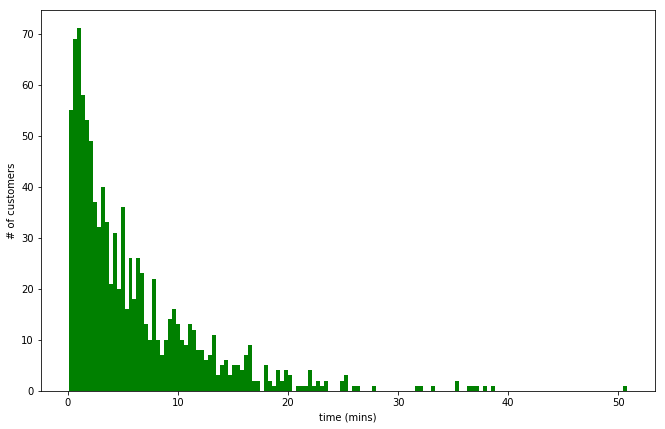

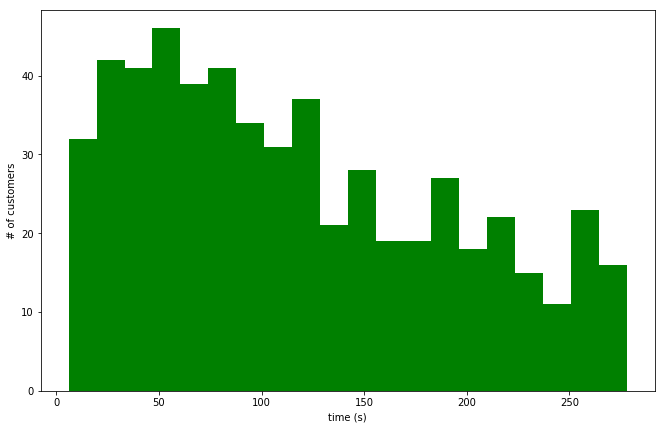

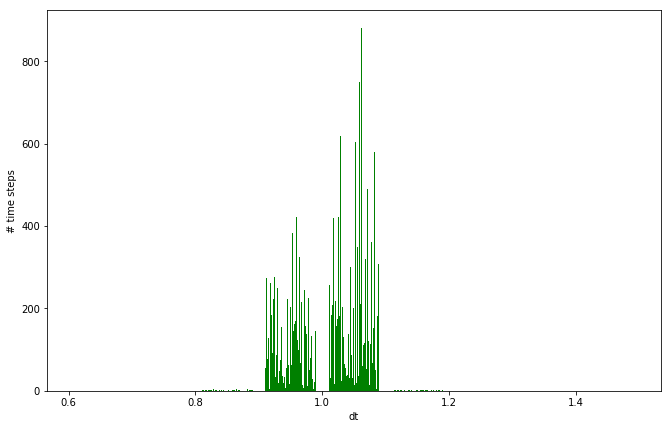

In [100]:
def time_histogram(df):
    a = np.array([(e[-1] - e[0]).total_seconds()/60 for e in df["positions_time"]])
    plt.xlabel("time (mins)")
    plt.ylabel("# of customers")
    n, bins, patches = plt.hist(a, 140, density=False, facecolor='g')

    plt.figure()
    a = np.array([(e[-1] - e[0]).total_seconds() for e in df["positions_time"]])
    a = a[a < 280]
    plt.xlabel("time (s)")
    plt.ylabel("# of customers")
    n, bins, patches = plt.hist(a, 20, density=False, facecolor='g')

    plt.figure()
    a = np.array([np.vectorize(lambda x: x.total_seconds())(np.diff(e)) for e in df["positions_time"]])
    plt.xlabel("dt")
    plt.ylabel("# time steps")
    plt.hist(a[1:90].ravel(), bins=np.linspace(0.6,1.5,10), density=False,facecolor='g')
    #print(a[0:1].ravel())
    plt.show()
    
time_histogram(df.copy())

# Models (and helper functions)

In [101]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def get_velocity(x,y,t):       
    dt = np.array([e.total_seconds() for e in np.diff(t)])
    
    # indices of splitting points
    i_split = np.argwhere(dt > 1.5).flatten()
    x_s = np.array(np.split(x, i_split))
    y_s = np.array(np.split(y, i_split))
    t_s = np.array(np.split(t, i_split))
    
    dt_s = np.array([np.array([e.total_seconds() for e in np.diff(series)]) for series in t_s])

    dx_s = [np.diff(e) for e in x_s]
    dy_s = [np.diff(e) for e in y_s]
    
    vx_s = dx_s/dt_s
    vy_s = dy_s/dt_s
    angle_s = np.array([np.arctan2(ex, ey) for ex,ey in zip(vx_s, vy_s)])
    v_s = (vx_s**2 + vy_s**2)**0.5
     
    omega_s = [np.diff(e) for e in angle_s]
    
    return v_s, vx_s, vy_s


In [125]:
from abc import ABC

class Classifier(ABC):
    """
        Abstract base class for all classifiers
    """
    def classify(self, x,y,t):
        pass
    
    def predict(self,df):
        mdf = df.apply(lambda x: self.classify(x['positions_x'], x['positions_y'], x['positions_time']), axis=1)
        return mdf
    
    def percentage_of_unserved(self,df):
        return (1-self.predict(df).mean())
    
    def test_on_customer(self,df,idx):
        # this method tests the classifier on a given customer
        return self.classify(df.iloc[idx].positions_x, df.iloc[idx].positions_y, df.iloc[idx].positions_time)

    
class Model1(Classifier):
    """
        Naive classifier - we just monitor if customers walk into the are where desks are.
        
        It should however provide a sensible lower bound of the actual result.
    """
    def classify(self, x,y,t):
        x = np.array(x)
        y = np.array(y)
        
        spatial_regions = [np.logical_and(x>6, y<7+(x-4)*0.05), x>13.5]
        if (np.logical_or(*spatial_regions)).all():
            return False
        return True   
    
class Model2(Classifier):
    """
        Finds where customers don't move (according to their average velocity 
        and time duration of no movement period) and finds out if they stay in
        desks area.
    """
    @staticmethod
    def is_moving(x,y,t, thr=0.25):
        """
          This function returns bool array stating when the customer is in movement.
          It uses two methods:
            - if moving average of abs(velocity) is above threashold (TODO delete this)
            - if distance travelled in recent past is above threashold
          Function is static and can be used separately.
          
          INPUTS:
            x,y,t  - np.ndarray of x,y,t data
            thr    - threashold velocity to trigger movement
        """
        # some random notes: [3], [40] to check precision-recall
        
        # get velocity vs time
        #   note: get_velocity returns list of velocities, because some data is dijoined
        vs, vxs, vys = get_velocity(x,y,t)
        moving = np.zeros(len(x), dtype=bool)

        # for every disjoined segment we parse it separately
        offset = 0
        
        for a,b,c in zip(vs, vxs, vys):

            # calculate displacements (= rolling average of vx, vy), and the total displacement pr_vs
            r_vxs = pd.Series(b).rolling(6, min_periods=1).mean().to_numpy()      
            r_vys = pd.Series(c).rolling(6, min_periods=1).mean().to_numpy()
            pr_vs = (r_vxs**2 + r_vys**2)**0.5
            
            ind_pr_vs = np.argwhere(pr_vs > thr)
            #print(pr_vs)
            
            ind = offset + ind_pr_vs
            moving[ind] = 1
            offset += len(a)
        
        return moving
        
    def classify(self, x,y,t):
        x = np.array(x)
        y = np.array(y)
        t = np.array(t)
        
        
        moving = self.is_moving(x,y,t)
        
        # find regions of no movement and sort them according to time duration
        regions = scipy.ndimage.find_objects(scipy.ndimage.label(np.logical_not(moving))[0])
        decorated = [(t[e[0].stop-1] - t[e[0].start], e) for e in regions]
        decorated.sort(reverse=True)
        sorted_regions = [e for _,e in decorated]

        
        for reg in sorted_regions:
            dt = (t[reg[0].stop-1] - t[reg[0].start]).total_seconds()
            if dt < 10:
                # at least 10 seconds
                break
            
            
            indices = np.arange(reg[0].start, reg[0].stop)
            x0 = np.mean(x[indices])
            y0 = np.mean(y[indices])
            
            spatial_regions = [np.logical_and(x0>6, y0<6.5+(x0-4)*0.05), x0>13.5]
            if not (np.logical_or(*spatial_regions)):
                return True
            
        return False
            

class Model3(Classifier):
    
    """
        This model deteremines the time spent in the area with desks and classifies
        customers wrt a given threshold (default 13s)
    """
    
    
    # here we defined init function to define the parameter thr
    # the default value was optimized wrt. Model2
    def __init__(self, thr=13.):
        self.thr = thr
        
    def classify(self, x, y, t):
        spatial_regions = [np.logical_and(x>6, y<7+(x-4)*0.05), x>13.5]
        indices = np.where(np.logical_not(np.logical_or(*spatial_regions)))
        
        dt = np.insert(np.array([e.total_seconds() for e in np.diff(t)]), -1, 0)
        
        time = sum(dt[(indices)])
        return (time > self.thr)

class Model4(Classifier):
    """
        This model classifies customers be exploring the heatmap generated using 
        (generate_unique_heatmap)
        
        
    """
    
    def classify(self, x, y, t):
        d = pd.DataFrame(data= {'positions_x': [x], 'positions_y': [y], 'positions_time': [t]})
        h = generate_equal_customer_heatmap(d, bins=300, contrast=1.5, no_plot=True)


        indices = peak_local_max(h,20)
        coords = np.asfarray(indices)
        coords[:,1] = (coords[:,1])/300.*(X_max- X_min) + X_min
        coords[:,0] = (coords[:,0])/300.*(Y_max- Y_min) + Y_min

        heights = sorted([(h[e[0], e[1]], tuple(e), tuple(f))  for e,f in zip(indices,coords)], reverse=True)
        heights = [(e[0]/heights[0][0], e[1], e[2]) for e in heights]

        
        for e in heights:
            if e[0] < 0.1: break
            
            cx = e[2][1]
            cy = e[2][0]
            
            spatial_regions = [np.logical_and(cx>6, cy<7+(cx-4)*0.05), cx>13.5]
            if not (np.logical_or(*spatial_regions)).all():
                return True
            
        return False
            

        plt.plot(coords[:,1], coords[:,0], '.')
        plt.xlim([X_min, X_max])
        plt.ylim([Y_min, Y_max])
        plt.gca().set_aspect('equal')
        plt.show()


    

        
m1 = Model1()
m2 = Model2()
m3 = Model3()
m4 = Model4()
      

### What percentage of people left because of the queue?

In [126]:
print("Model 1:" , m1.percentage_of_unserved(df) )
print("Model 2:" , m2.percentage_of_unserved(df) )
print("Model 3:" , m3.percentage_of_unserved(df) )
print("Model 4:" , m4.percentage_of_unserved(df) )

Model 1: 0.1553588987217306


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


Model 2: 0.22418879056047203
Model 3: 0.2468043264503441
Model 4: 0.23500491642084564


# Further visualisations

Plot of the velocity and determination when customer is not moving

In [ ]:
# plot
def plot_velocity(df, idx):
    """
      plots velocity of customer
      INPUTS:
          df = DataFrame
          idx = ID of the customer
    """
    
    x = df.iloc[idx].positions_x
    y = df.iloc[idx].positions_y
    t = df.iloc[idx].positions_time
    
    dt = np.array([e.total_seconds() for e in np.diff(t)])
    
    # indices of splitting points
    i_split = np.argwhere(dt > 1.5).flatten()
    x_s = np.array(np.split(x, i_split))
    y_s = np.array(np.split(y, i_split))
    t_s = np.array(np.split(t, i_split))
    
    dt_s = np.array([np.array([e.total_seconds() for e in np.diff(series)]) for series in t_s])

    dx_s = [np.diff(e) for e in x_s]
    dy_s = [np.diff(e) for e in y_s]
    
    vx_s = dx_s/dt_s
    vy_s = dy_s/dt_s
    angle_s = np.array([np.arctan2(ex, ey) for ex,ey in zip(vx_s, vy_s)])
    v_s = (vx_s**2 + vy_s**2)**0.5
     
    omega_s = [np.diff(e) for e in angle_s]
    
    
    for svx, svy, sv,st in zip(vx_s,vy_s,v_s,t_s):
        Mdt = [e.total_seconds() for e in (st[:-1] - t[0])]
        
        r_vxs = pd.Series(svx).rolling(6, min_periods=1).mean().to_numpy()      
        r_vys = pd.Series(svy).rolling(6, min_periods=1).mean().to_numpy()
        pr_vs = (r_vxs**2 + r_vys**2)**0.5
        
        plt.plot(Mdt[1:],pr_vs[1:])
        
    plt.title("velocity vs time")
    plt.ylabel("Velocity")
    plt.xlabel("time (s)")
    plt.show()
    
    plt.figure()
    for sx, sy, st in zip(x_s, y_s, t_s):
        moving = Model2.is_moving(sx,sy,st)
        plt.plot(sx[moving],sy[moving], 'b.')
        plt.plot(sx[np.logical_not(moving)],sy[np.logical_not(moving)], 'r.')
    plt.gca().set_aspect('equal')
    plt.ylim(Y_min, Y_max)
    plt.xlim(X_min, X_max)
    plt.title("Trajectory of the customer: BLUE - moving, RED - not moving")
    plt.show()

  
plot_velocity(df, 194)

## Animation of the movement of a customer

In [ ]:
from matplotlib import animation,rc
from IPython.display import HTML

def animate_customer(df, idx):
    """
        Creates an animation of the customer's movement.
        
        Animation is to be run using: HTML(anim.to_html5_video())
        
        INPUTS:
            df = DataFrame
            idx = ID of customer
            
        
    
    """
    fig,ax = plt.subplots()
    plt.gca().set_aspect('equal')
    plt.xlim(X_min, X_max)
    plt.ylim(Y_min, Y_max)
    patch_g = plt.Circle((0,0), 0.1, fc='b')
    patch_r = plt.Circle((0,0), 0.1, fc='r')
    
    moving = Model2.is_moving(df.iloc[idx].positions_x, df.iloc[idx].positions_y, df.iloc[idx].positions_time)

    def animate(i):
           # accepts time since beginning
        
        customer_data_time_seconds = np.array([e.total_seconds() for e in (df.iloc[idx].positions_time - df.iloc[idx].positions_time[0])])
        p_idx =(np.abs(customer_data_time_seconds - i)).argmin()
        x = df.iloc[idx].positions_x[p_idx]
        y = df.iloc[idx].positions_y[p_idx]
        plt.legend([str(p_idx) + ", time: " + str(i) + "s"])


        if moving[p_idx]:
            patch_g.center = (x, y)
            patch_r.center = (-10, -10) # outside the screen - ugly but quick solution
            return patch_g,
        else:
            patch_r.center = (x, y)
            patch_g.center = (-10, -10) # outside the screen - ugly but quick solution
            return patch_r,
        
        

    def init():
       #patch.center = (8.,8.)
        ax.add_patch(patch_r)
        ax.add_patch(patch_g)
        return patch_r, patch_g

    frames = int((df.iloc[idx].positions_time[-1] - df.iloc[idx].positions_time[0]).total_seconds())
    anim = animation.FuncAnimation(fig, animate, 
                                   init_func=init, 
                                   frames=frames, 
                                   interval=1000//20,
                                   blit=True)

    return anim



anim = animate_customer(df, 194)
HTML(anim.to_html5_video())